# Generative Adversarial Networks

![GAN](notebook_images/gan.jpg) 

## References:

- Generative Adversarial NetworksGenerative Adversarial Networks, Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua BengioIan J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio, https://arxiv.org/abs/1406.2661
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial NetworksUnsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, Alec Radford, Luke Metz, Soumith ChintalaAlec Radford, Luke Metz, Soumith Chintala, https://arxiv.org/abs/1511.06434

- Ahlad Kumar, Deep Learning 27 - 37: GAN and WGAN, https://www.youtube.com/watch?v=RRTuumxm3CE

Most code from https://www.tensorflow.org/tutorials/generative/dcgan

In [90]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Input
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from IPython import display

import math
import numpy as np

import os
import time

In [91]:
def show_batch(image_batch):
    columns = 8
    rows = len(image_batch) / columns + 1  
    plt.figure(figsize=(16, 2 * rows))
    for n in range(len(image_batch)):
        ax = plt.subplot(int(rows), columns, n+1)
        plt.imshow((image_batch[n]), cmap='gray')
        plt.axis('off')
        
        
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')

    plt.savefig(f'{image_path}/image_{dataset}_{LATENT_DIM}_{epoch:04d}.png')
    plt.show()   


# assumes len samples is a perfect square
def show_samples(samples):
    
    k = int(math.sqrt(len(samples)))
    fig = plt.figure(figsize=(k,k))
    
    for i in range(len(samples)):
        plt.subplot(k, k, i+1)
        plt.imshow(np.asarray(samples)[i, :, :, 0], cmap='gray')
        plt.axis('off')    


In [92]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32

LATENT_DIM = 16

WIDTH = 28
HEIGHT = 28
NUM_CHANNELS = 1

model_path = 'd:/vcpi/DL09/dcgan'
image_path = 'mnist_results'

dataset = 'mnist'

train_online = True

## Load and prepare data

In [93]:
# load dataset
if dataset == 'fashion_mnist':
    (train_X, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
else:
    (train_X, _), (_, _) = tf.keras.datasets.mnist.load_data()

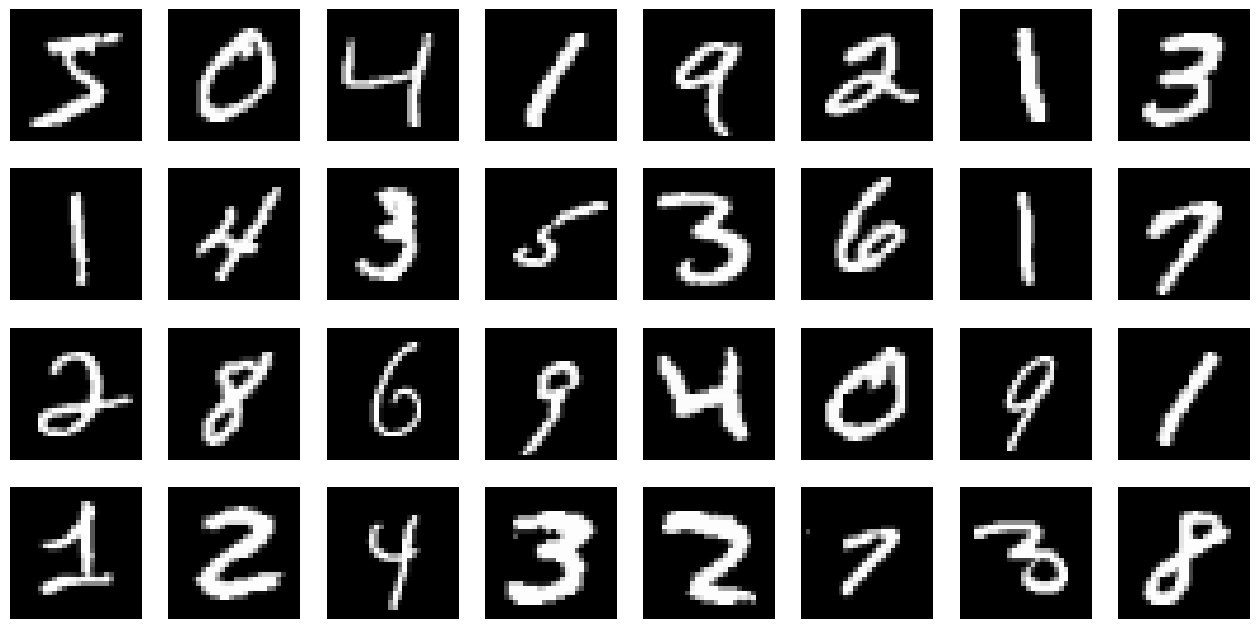

In [94]:
image_batch = train_X[:32]       
show_batch(image_batch)

# Process Data

data is reshaped from [X, 28,28] to [X, 28, 28, 1] and divided by 255 to normalize pixel values in the range [0,1]

In [95]:
# reshape and normalize
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32') / 255.0

# convert to tensors
train_dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define and build models

## Discriminator

In [96]:
disc_inputs = Input(shape = (WIDTH, HEIGHT, NUM_CHANNELS))


discriminator = Conv2D(32, (5, 5), strides=2, 
                       padding='same',  
                       input_shape=[28, 28, 1])(disc_inputs)
discriminator = LeakyReLU(alpha=0.2)(discriminator)

discriminator = Conv2D(64, (3, 3), strides=2, padding="same")(discriminator)
discriminator = LeakyReLU(alpha=0.2)(discriminator)
discriminator = BatchNormalization()(discriminator)

discriminator = Flatten()(discriminator)

discriminator = Dense(1,activation = 'sigmoid')(discriminator)

discriminator = Model(disc_inputs, discriminator)

discriminator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 batch_normalization_25 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                           

## Generator

In [97]:
generator = tf.keras.Sequential(name="Generator")

generator.add(Dense(512, input_shape=(LATENT_DIM,)))
generator.add(LeakyReLU())
generator.add(BatchNormalization())

generator.add(Dense(7*7*64))
generator.add(LeakyReLU())
generator.add(BatchNormalization())

generator.add(Reshape((7, 7, 64)))

generator.add(Conv2DTranspose(32, (3,3), strides=2, padding='same'))
generator.add(LeakyReLU())
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, (3,3), strides=2, padding='same'))
generator.add(LeakyReLU())
generator.add(BatchNormalization())


generator.add(Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid'))

generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               8704      
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 3136)              1608768   
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 3136)              0         
                                                                 
 batch_normalization_27 (Bat  (None, 3136)             12544     
 chNormalization)                                        

# Test setup

## Generate noise and generate image

1/1 [==============================] - 0s 181ms/step


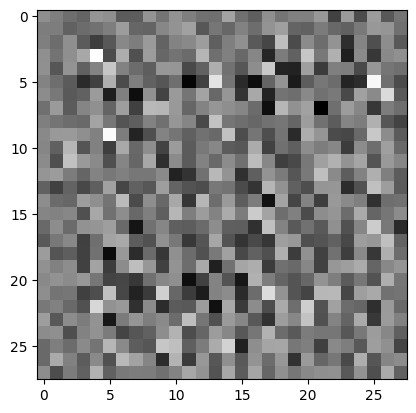

In [98]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator.predict(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Test fake and real data on discriminator

In [99]:
fake_pred = discriminator(generated_image)
print ('Fake pred: ', fake_pred.numpy()[0])

real_pred = discriminator(train_X[:1]) 
print('Real pred: ', real_pred.numpy()[0])

Fake pred:  [0.49652445]
Real pred:  [0.4990662]


# Prepare for training

## Define optimizers

In [100]:
InitLR = 2e-4
EPOCHS = 50

generator_optimizer = tf.keras.optimizers.Adam(InitLR, beta_1=0.3)
discriminator_optimizer = tf.keras.optimizers.Adam(InitLR, beta_1=0.3)

## Define checkpoint 

In [101]:
checkpoint_dir = f'{model_path}/{dataset}_{LATENT_DIM}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)

## Loss function definition


In [102]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [103]:
EPOCHS = 25
num_examples_to_generate = 16

noise_test = tf.random.normal([num_examples_to_generate, LATENT_DIM])

@tf.function
def train_step(images):
    
    # create noise vectors
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate images from noise
        generated_images = generator(noise, training=True)

        # compute discriminator output in real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # get gradients regarding weights
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                            generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                            discriminator.trainable_variables)

    # update weigths based on gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

    return gen_loss, disc_loss


In [104]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 noise_test)

        # Save the model every 10 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print("gen loss : ",gen_loss.numpy())
        print("disc loss: ",disc_loss.numpy())
        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             noise_test)

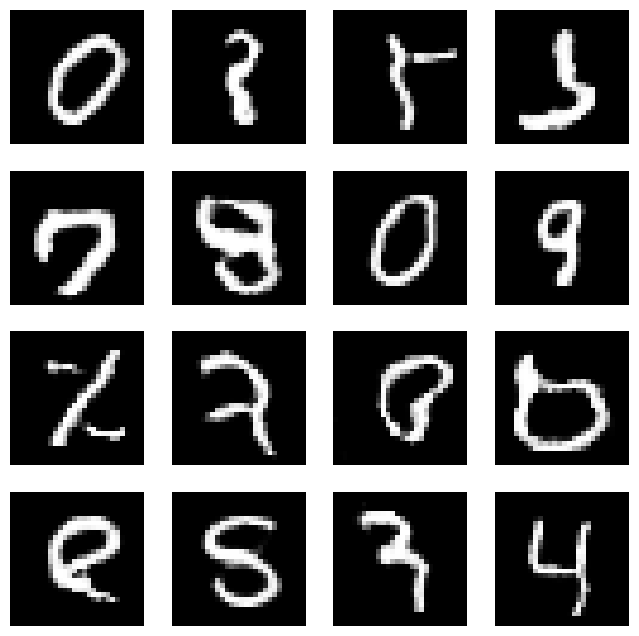

In [105]:
if train_online:
    train(train_dataset, EPOCHS)

In [106]:

checkpoint.restore(f'{checkpoint_prefix}-5')

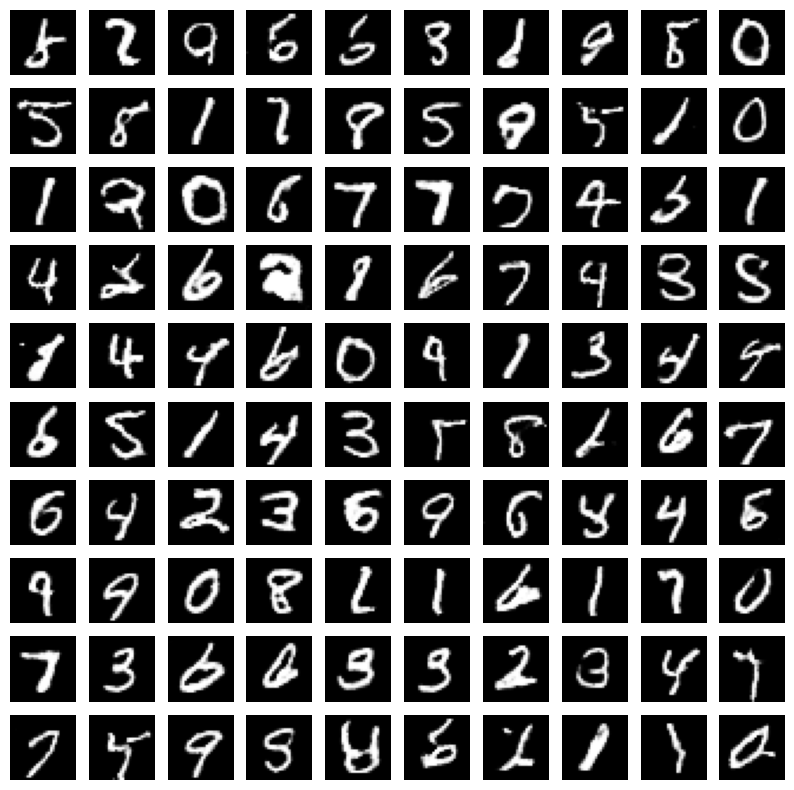

In [107]:
noise_test = tf.random.normal([100, LATENT_DIM])
predictions = generator(noise_test, training=False)

show_samples(predictions)
